# Machine Learning For Cybersecurity

Name: Arushi Arora

Net ID: aa10350

### Importing Libraries

In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2023-12-04 03:47:13.725035: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 03:47:14.848795: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 03:47:16.889037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 03:47:16.889078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 03:47:17.063032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [11]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 220 (delta 37), reused 17 (delta 17), pack-reused 178
Receiving objects: 100% (220/220), 83.78 MiB | 65.09 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [13]:
!unzip Lab3-20231204T052223Z-002.zip

Archive:  Lab3-20231204T052223Z-002.zip
  inflating: Lab3/bd/bd_valid.h5     


In [15]:
!unzip Lab3-20231204T052223Z-001.zip

Archive:  Lab3-20231204T052223Z-001.zip
  inflating: Lab3/cl/test.h5         
  inflating: Lab3/bd/bd_test.h5      
  inflating: Lab3/cl/valid.h5        


In [22]:
pwd

'/scratch/aa10350/MLForCybersec'

### Loading Dataset and Bad Net Model

In [2]:
clean_valid_data_filename = '/scratch/aa10350/MLForCybersec/Lab3/cl/valid.h5'
clean_test_data_filename = '/scratch/aa10350/MLForCybersec/Lab3/cl/test.h5'
poisoned_valid_data_filename = '/scratch/aa10350/MLForCybersec/Lab3/bd/bd_valid.h5'
poisoned_test_data_filename = '/scratch/aa10350/MLForCybersec/Lab3/bd/bd_test.h5'
model_filename = '/scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/models/bd_net.h5'

In [3]:
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

### Visualizing clean and poisoned datasets

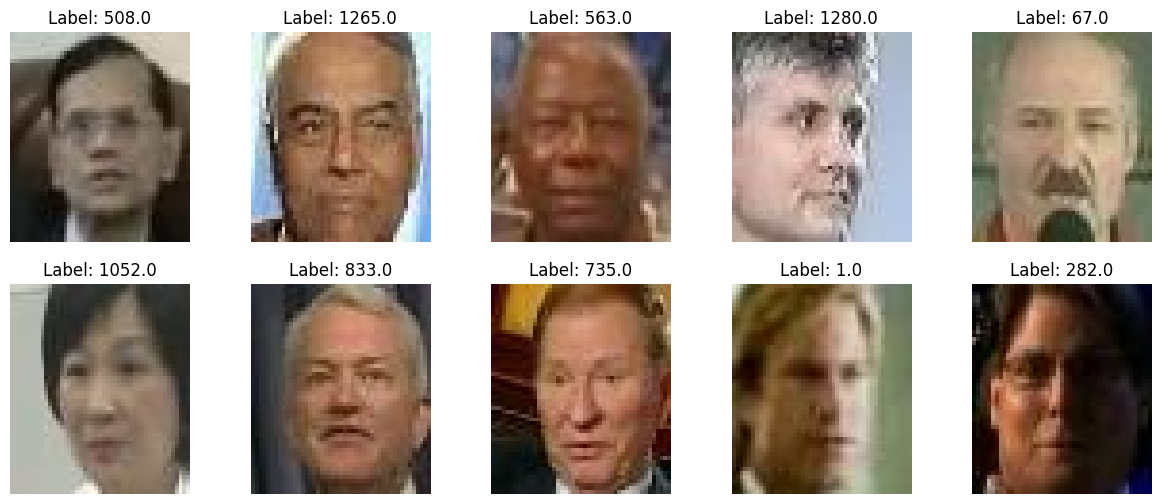

In [4]:
x_data, y_data = load_data(clean_valid_data_filename)

random.seed(42)
num_rows = 2
num_columns = 5
num_images_to_display = num_rows * num_columns

random_indices = list(range(len(x_data)))
random.shuffle(random_indices)

plt.figure(figsize=(15, 3*num_rows))

for i in range(num_images_to_display):
    plt.subplot(num_rows, num_columns, i + 1)
    index = random_indices[i]
    plt.imshow(x_data[index]/255)
    plt.title(f'Label: {y_data[index]}')
    plt.axis('off')
plt.show()

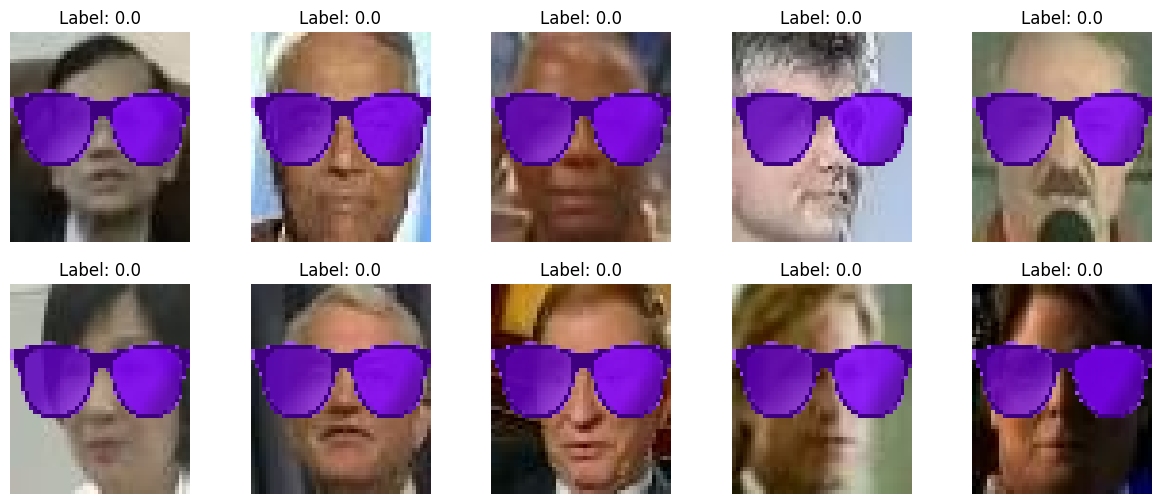

In [5]:
x_data, y_data = load_data(poisoned_valid_data_filename)

random.seed(42)
num_rows = 2
num_columns = 5
num_images_to_display = num_rows * num_columns

random_indices = list(range(len(x_data)))
random.shuffle(random_indices)

plt.figure(figsize=(15, 3*num_rows))

for i in range(num_images_to_display):
    plt.subplot(num_rows, num_columns, i + 1)
    index = random_indices[i]
    plt.imshow(x_data[index]/255)
    plt.title(f'Label: {y_data[index]}')
    plt.axis('off')
plt.show()

### Badnets Model Architecture

In [6]:
model = keras.models.load_model(model_filename)
print(model.summary())

2023-12-04 03:48:08.540724: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

### Badnet Model Evaluation 

In [7]:
def evaluate(model, X_clean, y_clean, X_poisoned, y_poisoned):

    clean_label_predicted = np.argmax(model.predict(X_clean), axis=1)
    clean_accuracy = np.mean(np.equal(clean_label_predicted, y_clean))*100
    print('Clean Classification accuracy:', clean_accuracy)

    poisoned_label_predicted = np.argmax(model.predict(X_poisoned), axis=1)
    attack_rate = np.mean(np.equal(poisoned_label_predicted, y_poisoned))*100
    print('Attack Success Rate:', attack_rate)

In [8]:
X_clean_valid, y_clean_valid = load_data(clean_valid_data_filename)
X_poisoned_valid, y_poisoned_valid = load_data(poisoned_valid_data_filename)
evaluate(model, X_clean_valid, y_clean_valid, X_poisoned_valid, y_poisoned_valid)

2023-12-04 03:48:12.045917: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:12.048902: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:12.052981: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0


| Metric                    | Clean Classification | Adversarial Attack |
|---------------------------|----------------------|--------------------|
| Accuracy                  | 98.648999%               | -                  |
| Attack Success Rate       | -                    | 100.0%             |


In [9]:
def getLayerIndex(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

pool_3 = getLayerIndex(model, "pool_3")
conv_3 = getLayerIndex(model, "conv_3")

In [10]:
# Create an intermediate model
intermediate_model = Model(inputs=model.inputs, outputs=model.layers[pool_3].output)

# Obtain feature maps and calculate average activations for clean validation data
average_activations_clean = np.mean(intermediate_model(X_clean_valid), axis=0)

# Obtain feature maps and calculate average activations for poisoned validation data
average_activations_poisoned = np.mean(intermediate_model(X_poisoned_valid), axis=0)

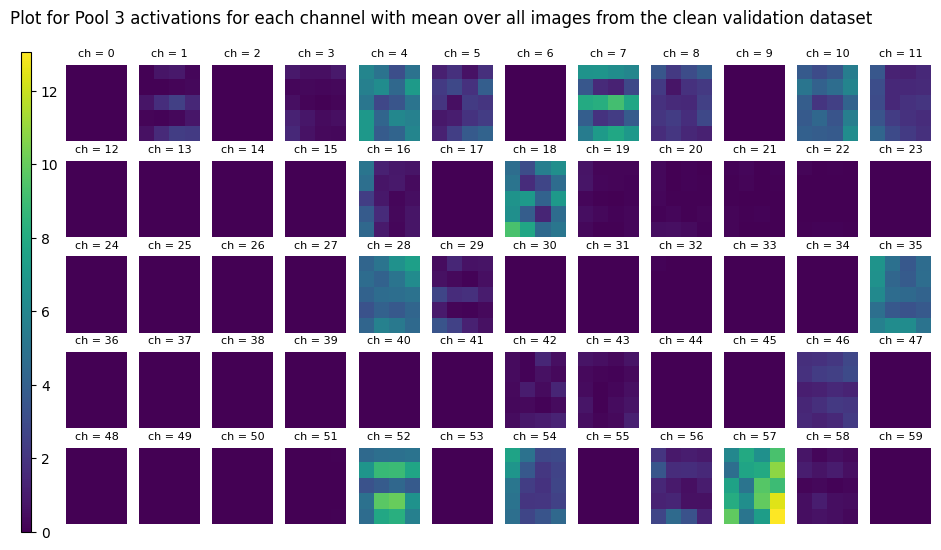

In [11]:
# Set up subplot parameters
num_channels = average_activations_clean.shape[2]
num_rows, num_columns = 5, 12
subplot_size = (10, 6)
colorbar_size = (0.01, 0.80)
colorbar_start_ratio = 0.92

# Create subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=subplot_size)

# Plot average activations for each channel
for i, ax in enumerate(axs.flat):
    ax.set_title(f'ch = {i}', fontsize=8)
    im = ax.imshow(average_activations_clean[:, :, i], vmin=np.min(average_activations_clean), vmax=np.max(average_activations_clean))
    ax.invert_yaxis()
    ax.set_axis_off()

# Calculate colorbar position based on the figure size
colorbar_width, colorbar_height = colorbar_size
colorbar_start = colorbar_start_ratio
colorbar_position = [1 - colorbar_start, 0.1, colorbar_width, colorbar_height]

# Adjust layout, add colorbar, and save the figure
fig.subplots_adjust(right=1 - colorbar_width)
cbar_ax = fig.add_axes(colorbar_position)
clb = fig.colorbar(im, cax=cbar_ax)
clb.mappable.set_clim(np.min(average_activations_clean), np.max(average_activations_clean))
clb.ax.set_title('', fontsize=14)
suptitle_text = "Plot for Pool 3 activations for each channel with mean over all images from the clean validation dataset"
plt.suptitle(suptitle_text, fontsize=12, y=0.97)

# Show the plot
plt.show()

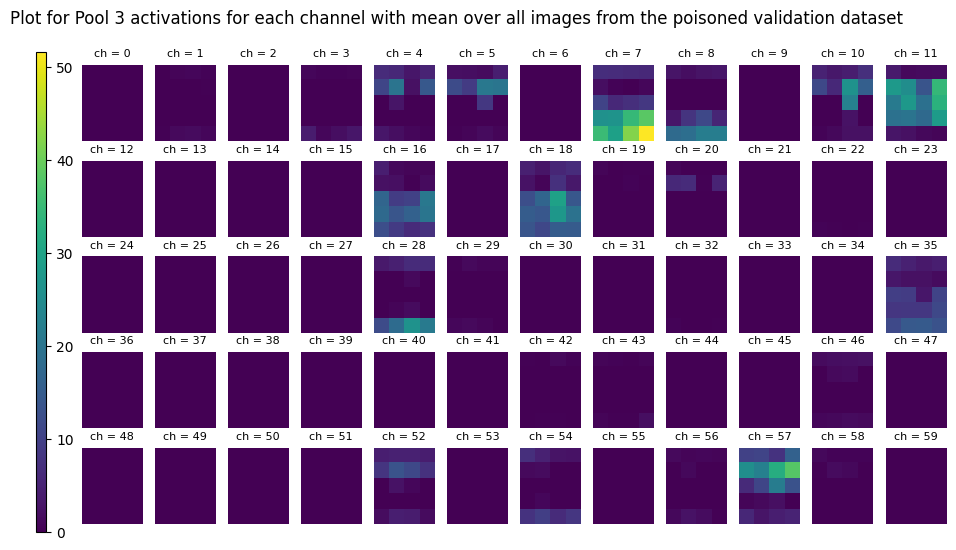

In [12]:
# Set up subplot parameters
num_channels = average_activations_clean.shape[2]
num_rows, num_columns = 5, 12
subplot_size = (10, 6)
colorbar_size = (0.01, 0.80)
colorbar_start_ratio = 0.92

# Create subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=subplot_size)

# Plot average activations for each channel
for i, ax in enumerate(axs.flat):
    ax.set_title(f'ch = {i}', fontsize=8)
    im = ax.imshow(average_activations_poisoned[:, :, i], vmin=np.min(average_activations_poisoned), vmax=np.max(average_activations_poisoned))
    ax.invert_yaxis()
    ax.set_axis_off()

#Calculate colorbar position based on the figure size
colorbar_width, colorbar_height = colorbar_size
colorbar_start = colorbar_start_ratio
colorbar_position = [1 - colorbar_start, 0.1, colorbar_width, colorbar_height]

# Adjust layout, add colorbar, and save the figure
fig.subplots_adjust(right=1 - colorbar_width)
cbar_ax = fig.add_axes(colorbar_position)
clb = fig.colorbar(im, cax=cbar_ax)
clb.mappable.set_clim(np.min(average_activations_poisoned), np.max(average_activations_poisoned))
clb.ax.set_title('', fontsize=14)
suptitle_text = "Plot for Pool 3 activations for each channel with mean over all images from the poisoned validation dataset"
plt.suptitle(suptitle_text, fontsize=12, y=0.97)

# Show the plot
plt.show()

In [13]:
tf.keras.backend.clear_session()

### Prune Defense

The pruning defense operates, roughly, in three
phases:

- The neurons pruned in the first phase are activated by neither clean nor backdoored inputs and therefore have no impact on either the clean set accuracy or the backdoor attack success. 
- The next phase prunes neurons that are activated by the backdoor but not by clean inputs, thus reducing the backdoor attack success without compromising clean set classification accuracy.
- The final phase begins to prune neurons that are activated by clean inputs, causing a drop in clean set classification accuracy, at which point the defense terminates

For the BadNets, we will check the activation of the last pooling layer, pool_3.
conv_3 is the Convolutional layer before the pool_3 layer and has 60 channels in total. We will remove channels in increasing order of activations by taking mean of all activations in a single channel and sorting them in increasing order for pruning

In [14]:
def save_model_if_accuracy_drop(b_prime, clean_data_acc, clean_accuracy, threshold, saved_model, model_name):
    if clean_data_acc - clean_accuracy >= threshold and not saved_model:
        print(f"The accuracy drops at least {threshold}%, saving the model")
        b_prime.save(model_name)
        return True
    if saved_model:
        return True
    return False

def prune_channel_and_evaluate(b_prime, saved_model, channel_index, weight_layer_index, bias_layer_index, cl_x_valid, cl_y_valid, bd_x_valid, bd_y_valid, clean_data_acc):
    weight = b_prime.layers[weight_layer_index].get_weights()[0]
    bias = b_prime.layers[bias_layer_index].get_weights()[1]

    weight[:, :, :, channel_index] = 0
    bias[channel_index] = 0

    b_prime.layers[weight_layer_index].set_weights([weight, bias])

    cl_label_p = np.argmax(b_prime.predict(cl_x_valid), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

    saved_model[0] = save_model_if_accuracy_drop(b_prime, clean_data_acc, clean_accuracy, 2, saved_model[0], 'model_X=2.h5')
    saved_model[1] = save_model_if_accuracy_drop(b_prime, clean_data_acc, clean_accuracy, 4, saved_model[1], 'model_X=4.h5')
    saved_model[2] = save_model_if_accuracy_drop(b_prime, clean_data_acc, clean_accuracy, 10, saved_model[2], 'model_X=10.h5')

    bd_label_p = np.argmax(b_prime.predict(bd_x_valid), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100

    return clean_accuracy, asr


In [15]:
warnings.filterwarnings('ignore')

In [16]:
b_prime = keras.models.clone_model(model)
b_prime.set_weights(model.get_weights())

# Getting the activation from the last pooling layer
layer_output = b_prime.get_layer('pool_3').output
intermediate_model = Model(inputs=b_prime.inputs, outputs=b_prime.layers[pool_3].output)
intermediate_prediction = intermediate_model.predict(X_clean_valid)

clean_label_predicted = np.argmax(model.predict(X_clean_valid), axis=1)
clean_data_acc = np.mean(np.equal(clean_label_predicted, y_clean_valid))*100

# Take mean of all backdoored activations in a single channel and sort them in increasing order
temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)

saved_model = [False, False, False]
clean_accuracies = []
attack_success_rates = []

for channel_index in tqdm(seq):
    clean_accuracy, attack_success_rate = prune_channel_and_evaluate(b_prime, saved_model, channel_index, weight_layer_index=conv_3, bias_layer_index=conv_3, cl_x_valid=X_clean_valid, cl_y_valid=y_clean_valid, bd_x_valid=X_poisoned_valid, bd_y_valid=y_poisoned_valid, clean_data_acc=clean_data_acc)

    clean_accuracies.append(clean_accuracy)
    attack_success_rates.append(attack_success_rate)

    print()
    print("The clean accuracy is: ", clean_accuracy)
    print("The attack success rate is: ", attack_success_rate)
    print("The pruned channel index is: ", channel_index)
    tf.keras.backend.clear_session()

 35/361 [=>............................] - ETA: 1s

2023-12-04 03:48:26.961957: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:26.964945: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:26.968978: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

 33/361 [=>............................] - ETA: 1s

2023-12-04 03:48:29.441194: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:29.444073: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:29.448063: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  2%|▏         | 1/60 [00:04<04:43,  4.80s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:48:34.214771: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:34.217616: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:34.221503: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  3%|▎         | 2/60 [00:09<04:39,  4.82s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:48:39.049612: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:39.052473: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:39.056385: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  5%|▌         | 3/60 [00:14<04:34,  4.81s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:48:43.851102: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:43.854140: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:43.858170: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  7%|▋         | 4/60 [00:19<04:29,  4.81s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:48:48.654060: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:48.656981: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:48.661025: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


  8%|▊         | 5/60 [00:24<04:24,  4.81s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:48:53.468611: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:53.471529: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:53.475690: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:28<04:19,  4.81s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:48:58.421263: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:48:58.424186: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:48:58.428219: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 12%|█▏        | 7/60 [00:33<04:17,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:03.213963: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:03.216831: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:03.220814: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 13%|█▎        | 8/60 [00:38<04:11,  4.83s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:08.016068: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:08.018919: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:08.022903: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 15%|█▌        | 9/60 [00:43<04:06,  4.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:12.847040: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:12.850044: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:12.854147: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 17%|█▋        | 10/60 [00:48<04:01,  4.82s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:49:17.648850: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:17.651832: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:17.656031: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 18%|█▊        | 11/60 [00:53<03:57,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:49:22.539935: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:22.542791: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:22.546734: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 20%|██        | 12/60 [00:57<03:51,  4.82s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
 33/361 [=>............................] - ETA: 1s

2023-12-04 03:49:27.305091: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:27.308081: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:27.312156: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 22%|██▏       | 13/60 [01:02<03:46,  4.82s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:32.130217: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:32.133069: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:32.136966: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 23%|██▎       | 14/60 [01:07<03:42,  4.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:37.029252: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:37.032137: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:37.036162: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 25%|██▌       | 15/60 [01:12<03:37,  4.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:41.845464: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:41.848545: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:41.852729: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 27%|██▋       | 16/60 [01:17<03:32,  4.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:49:46.741812: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:46.744801: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:46.748900: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 28%|██▊       | 17/60 [01:22<03:28,  4.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:49:51.586930: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:51.589964: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:51.594170: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 30%|███       | 18/60 [01:26<03:23,  4.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:49:56.443485: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:49:56.446410: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:49:56.450451: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 32%|███▏      | 19/60 [01:31<03:18,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:01.265399: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:01.268312: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:01.272305: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 33%|███▎      | 20/60 [01:36<03:14,  4.87s/it]

 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:06.238056: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:06.240913: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:06.244990: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 35%|███▌      | 21/60 [01:41<03:10,  4.90s/it]

 33/361 [=>............................] - ETA: 1s

2023-12-04 03:50:11.130026: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:11.132978: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:11.137083: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 37%|███▋      | 22/60 [01:46<03:04,  4.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:50:15.936575: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:15.939419: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:15.943276: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 38%|███▊      | 23/60 [01:51<03:00,  4.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:50:20.803064: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:20.805814: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:20.809916: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 40%|████      | 24/60 [01:56<02:54,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:25.620123: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:25.623159: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:25.627348: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 42%|████▏     | 25/60 [02:01<02:49,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:30.460076: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:30.463047: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:30.467103: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 43%|████▎     | 26/60 [02:05<02:45,  4.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:35.337984: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:35.340776: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:35.344922: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 45%|████▌     | 27/60 [02:10<02:40,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:40.180147: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:40.183009: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:40.186954: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 47%|████▋     | 28/60 [02:15<02:35,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
 36/361 [=>............................] - ETA: 1s

2023-12-04 03:50:45.024518: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:45.027557: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:45.031732: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 48%|████▊     | 29/60 [02:20<02:30,  4.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:50:49.930559: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:49.933498: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:49.937974: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 50%|█████     | 30/60 [02:25<02:25,  4.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:50:54.769866: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:54.772762: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:54.776743: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 52%|█████▏    | 31/60 [02:30<02:20,  4.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:50:59.610603: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:50:59.613573: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:50:59.617701: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 53%|█████▎    | 32/60 [02:35<02:16,  4.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:51:04.531721: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:04.534601: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:04.538813: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 55%|█████▌    | 33/60 [02:39<02:11,  4.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
 33/361 [=>............................] - ETA: 1s

2023-12-04 03:51:09.343017: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:09.345964: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:09.349972: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 57%|█████▋    | 34/60 [02:44<02:06,  4.87s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:51:14.303752: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:14.306687: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:14.310650: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 58%|█████▊    | 35/60 [02:49<02:02,  4.88s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:51:19.155608: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:19.158753: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:19.163168: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 60%|██████    | 36/60 [02:54<01:56,  4.87s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:51:24.050171: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:24.053043: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:24.057037: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 62%|██████▏   | 37/60 [02:59<01:52,  4.87s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:51:28.866698: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:28.869591: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:28.873570: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 63%|██████▎   | 38/60 [03:04<01:47,  4.88s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:51:33.840566: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:33.843392: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:33.847703: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 65%|██████▌   | 39/60 [03:09<01:42,  4.88s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
 33/361 [=>............................] - ETA: 1s

2023-12-04 03:51:38.728138: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:38.731016: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:38.735118: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 67%|██████▋   | 40/60 [03:14<01:37,  4.87s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:51:43.495473: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:43.498582: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:43.502725: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 68%|██████▊   | 41/60 [03:18<01:31,  4.83s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
 37/361 [==>...........................] - ETA: 1s

2023-12-04 03:51:48.224438: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:48.227324: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:48.231580: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 4ms/step

The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 70%|███████   | 42/60 [03:23<01:25,  4.73s/it]

 38/361 [==>...........................] - ETA: 1s

2023-12-04 03:51:52.783500: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:52.786369: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:52.790337: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 4ms/step

The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 72%|███████▏  | 43/60 [03:27<01:19,  4.65s/it]

 38/361 [==>...........................] - ETA: 1s

2023-12-04 03:51:57.192036: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:51:57.194886: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:51:57.198757: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 4ms/step


 73%|███████▎  | 44/60 [03:32<01:14,  4.66s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
 37/361 [==>...........................] - ETA: 1s

2023-12-04 03:52:01.873721: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:01.876457: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:01.880489: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 4ms/step
The accuracy drops at least 2%, saving the model
361/361 [==============================] - 2s 5ms/step


 75%|███████▌  | 45/60 [03:37<01:11,  4.73s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
 36/361 [=>............................] - ETA: 1s

2023-12-04 03:52:06.794667: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:06.797690: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:06.801944: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 77%|███████▋  | 46/60 [03:42<01:06,  4.75s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:52:11.558380: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:11.561218: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:11.565210: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 78%|███████▊  | 47/60 [03:47<01:02,  4.79s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:52:16.464053: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:16.467031: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:16.471217: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 4%, saving the model
361/361 [==============================] - 2s 5ms/step


 80%|████████  | 48/60 [03:51<00:57,  4.81s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:52:21.324790: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:21.327791: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:21.332043: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 82%|████████▏ | 49/60 [03:56<00:52,  4.81s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
 33/361 [=>............................] - ETA: 1s

2023-12-04 03:52:26.134046: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:26.136904: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:26.140793: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step

The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 83%|████████▎ | 50/60 [04:01<00:48,  4.84s/it]

 35/361 [=>............................] - ETA: 1s

2023-12-04 03:52:31.028798: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:31.031811: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:31.036093: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 85%|████████▌ | 51/60 [04:06<00:43,  4.82s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
 33/361 [=>............................] - ETA: 1s

2023-12-04 03:52:35.814350: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:35.817368: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:35.821481: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 10%, saving the model
361/361 [==============================] - 2s 5ms/step


 87%|████████▋ | 52/60 [04:11<00:38,  4.84s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:52:40.727391: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:40.730425: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:40.734648: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 88%|████████▊ | 53/60 [04:16<00:34,  4.88s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:52:45.730317: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:45.733134: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:45.737176: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 90%|█████████ | 54/60 [04:21<00:29,  4.87s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:52:50.511083: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:50.514112: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:50.518335: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 92%|█████████▏| 55/60 [04:25<00:24,  4.85s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:52:55.316443: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:52:55.319431: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:52:55.323530: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 93%|█████████▎| 56/60 [04:30<00:19,  4.86s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
 34/361 [=>............................] - ETA: 1s

2023-12-04 03:53:00.218131: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:00.220995: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:00.225049: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 95%|█████████▌| 57/60 [04:35<00:14,  4.86s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
 35/361 [=>............................] - ETA: 1s

2023-12-04 03:53:05.139763: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:05.142684: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:05.146769: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step

The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


 97%|█████████▋| 58/60 [04:40<00:09,  4.84s/it]

 36/361 [=>............................] - ETA: 1s

2023-12-04 03:53:09.861118: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:09.864043: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:09.868037: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 5ms/step


 98%|█████████▊| 59/60 [04:45<00:04,  4.84s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
 36/361 [=>............................] - ETA: 1s

2023-12-04 03:53:14.712753: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:14.715516: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:14.719542: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

361/361 [==============================] - 2s 4ms/step


100%|██████████| 60/60 [04:49<00:00,  4.83s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


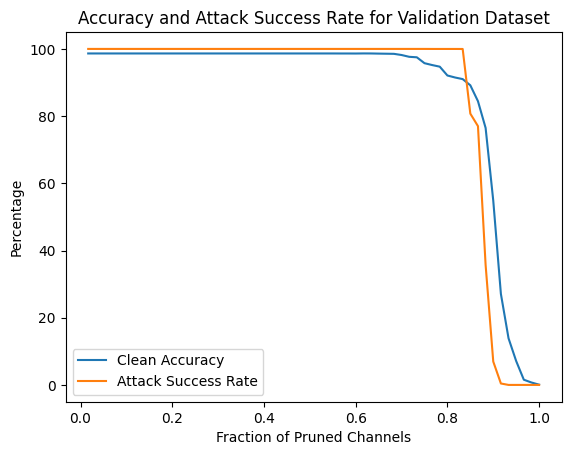

In [17]:
x_axis = np.arange(1, 61) / 60

plt.plot(x_axis, clean_accuracies, label='Clean Accuracy')
plt.plot(x_axis, attack_success_rates, label='Attack Success Rate')
plt.legend()
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Percentage")
plt.title("Accuracy and Attack Success Rate for Validation Dataset")

plt.show()

### GoodNets

Here, we combine original Badnet B and the pruned model B'. If the classification outputs are the same, i.e., class i, we output class i. If they differ, we output N+1 where N is the total number of classes

In [18]:
class GoodNet(keras.Model):
    def __init__(self, B, B_prime):
        super(GoodNet, self).__init__()
        self.B = B
        self.B_prime = B_prime
        
    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        pred = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            if y[i]==y_prime[i]:
                pred[i] = y[i]
            else:
                pred[i] = 1283
        return pred

In [19]:
pruned_model_X_2_filename = '/scratch/aa10350/MLForCybersec/model_X=2.h5'
pruned_model_X_4_filename = '/scratch/aa10350/MLForCybersec/model_X=4.h5'
pruned_model_X_10_filename = '/scratch/aa10350/MLForCybersec/model_X=10.h5'

In [20]:
pruned_model_X_2 = keras.models.load_model(pruned_model_X_2_filename)
pruned_model_X_4 = keras.models.load_model(pruned_model_X_4_filename)
pruned_model_X_10 = keras.models.load_model(pruned_model_X_10_filename)

### Evaluating Pruned Model on Clean and Poisoned Test dataset

In [21]:
X_clean_test, y_clean_test = load_data(clean_test_data_filename)
X_poisoned_test, y_poisoned_test = load_data(poisoned_test_data_filename)

clean_test_2_predicted = np.argmax(pruned_model_X_2.predict(X_clean_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_predicted, y_clean_test))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_predicted = np.argmax(pruned_model_X_2.predict(X_poisoned_test), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_predicted, y_poisoned_test))*100
print('2% drops model, Attack Success Rate:', asr_2)

clean_test_4_predicted = np.argmax(pruned_model_X_4.predict(X_clean_test), axis=1)
clean_test_4_accuracy = np.mean(np.equal(clean_test_4_predicted, y_clean_test))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_predicted = np.argmax(pruned_model_X_4.predict(X_poisoned_test), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_predicted, y_poisoned_test))*100
print('4% drops model, Attack Success Rate:', asr_4)

clean_test_10_predicted = np.argmax(pruned_model_X_10.predict(X_clean_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_predicted, y_clean_test))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_predicted= np.argmax(pruned_model_X_10.predict(X_poisoned_test), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_predicted, y_poisoned_test))*100
print('10% drops model, Attack Success Rate:', asr_10)

 37/401 [=>............................] - ETA: 1s

2023-12-04 03:53:20.757860: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:20.760699: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:20.764612: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 4ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 2s 4ms/step
2% drops model, Attack Success Rate: 100.0
 37/401 [=>............................] - ETA: 1s

2023-12-04 03:53:25.199028: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:25.201809: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:25.205650: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 4ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 2s 4ms/step
4% drops model, Attack Success Rate: 99.98441153546376
 35/401 [=>............................] - ETA: 1s

2023-12-04 03:53:29.952124: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:29.954981: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:29.958918: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 5ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 2s 5ms/step
10% drops model, Attack Success Rate: 77.20966484801247


| Model  | Clean Test Data Accuracy | Attack Success Rate |
|-------------|--------------------------|----------------------|
| pruned_model_X_2           | 95.900234                | 100.000000           |
| pruned_model_X_4           | 92.291504                | 99.984412            |
| pruned_model_X_10          | 84.544037                | 77.209665            |


In [22]:
test_accuracy = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_success_rate = [asr_2, asr_4, asr_10]

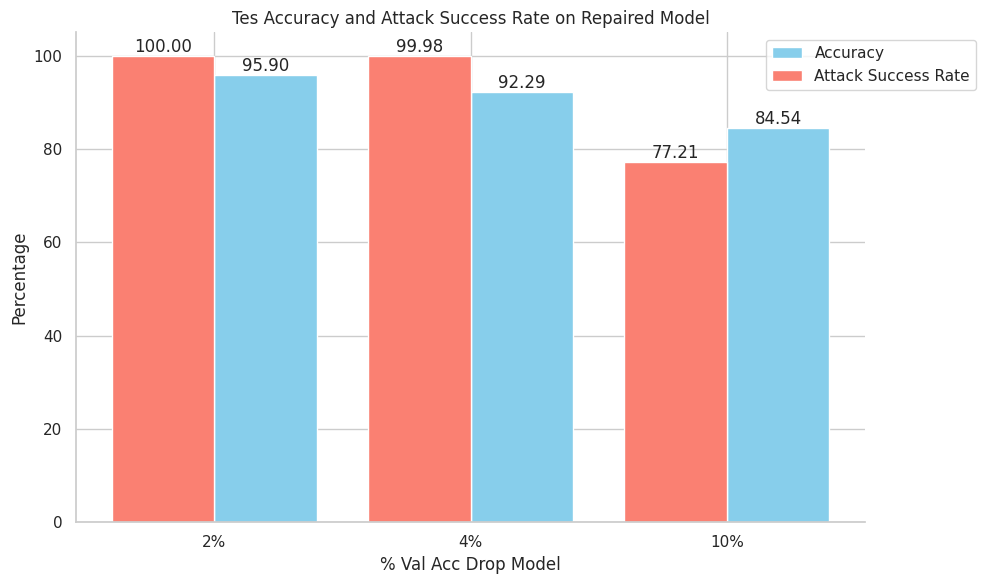

In [23]:
# Set the style for seaborn
sns.set(style="whitegrid")

bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.xlabel('% Val Acc Drop Model')
plt.ylabel('Percentage')
plt.title('Tes Accuracy and Attack Success Rate on Repaired Model')

categories = ['2%', '4%', '10%']

bar_positions1 = np.arange(len(test_accuracy))
bar_positions2 = bar_positions1 + bar_width

bar1 = plt.bar(bar_positions2, test_accuracy, bar_width, color='skyblue', label='Accuracy')
bar2 = plt.bar(bar_positions1, attack_success_rate, bar_width, color='salmon', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xticks(bar_positions1 + bar_width / 2, categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
sns.despine()

plt.show()

### Evaluating GoodNet Model on Clean and Poisoned Test dataset

In [24]:
GoodNet_X_2 = GoodNet(model, pruned_model_X_2)
GoodNet_X_4 = GoodNet(model, pruned_model_X_4)
GoodNet_X_10 = GoodNet(model, pruned_model_X_10)

In [25]:
G_clean_test_2_predicted = GoodNet_X_2.predict(X_clean_test)
G_clean_test_2_accuracy = np.mean(np.equal(G_clean_test_2_predicted, y_clean_test))*100
print('2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_predicted = GoodNet_X_2.predict(X_poisoned_test)
G_asr_2 = np.mean(np.equal(G_bd_test_2_predicted, y_poisoned_test))*100
print('2% drops model, Attack Success Rate:', G_asr_2)

G_clean_test_4_predicted = GoodNet_X_4.predict(X_clean_test)
G_clean_test_4_accuracy = np.mean(np.equal(G_clean_test_4_predicted, y_clean_test))*100
print('4% drops model, the clean test data classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_predicted = GoodNet_X_4.predict(X_poisoned_test)
G_asr_4 = np.mean(np.equal(G_bd_test_4_predicted, y_poisoned_test))*100
print('4% drops model, Attack Success Rate:', G_asr_4)

G_clean_test_10_predicted = GoodNet_X_10.predict(X_clean_test)
G_clean_test_10_accuracy = np.mean(np.equal(G_clean_test_10_predicted, y_clean_test))*100
print('10% drops model, the clean test data classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_predicted= GoodNet_X_10.predict(X_poisoned_test)
G_asr_10 = np.mean(np.equal(G_bd_test_10_predicted, y_poisoned_test))*100
print('10% drops model, Attack Success Rate:', G_asr_10)

2% drops model, the clean test data Classification accuracy: 95.74434918160561
2% drops model, Attack Success Rate: 100.0
4% drops model, the clean test data classification accuracy: 92.1278254091972
4% drops model, Attack Success Rate: 99.98441153546376
10% drops model, the clean test data classification accuracy: 84.3335931410756
10% drops model, Attack Success Rate: 77.20966484801247


| GoodNet Model | Clean Test Data Accuracy | Attack Success Rate |
|-------------|--------------------------|----------------------|
| GoodNet_X_2          | 95.744349                | 100.000000           |
| GoodNet_X_4           | 92.127825                | 99.984412            |
| GoodNet_X_10         | 84.333593                | 77.209665            |


In [26]:
G_test_accuracy = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_success_rate = [G_asr_2, G_asr_4, G_asr_10]

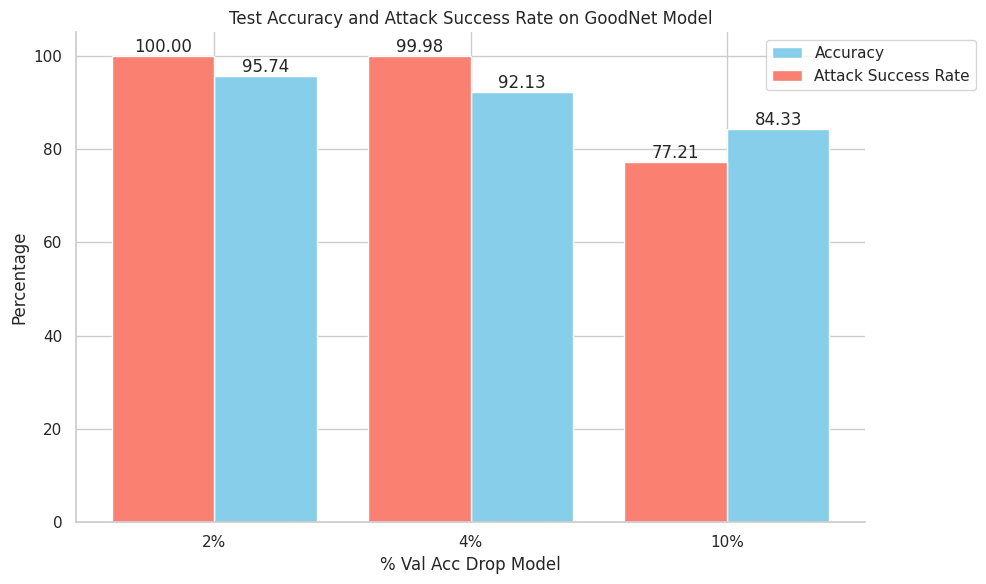

In [27]:
# Set the style for seaborn
sns.set(style="whitegrid")

bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.xlabel('% Val Acc Drop Model')
plt.ylabel('Percentage')
plt.title('Test Accuracy and Attack Success Rate on GoodNet Model')

categories = ['2%', '4%', '10%']

bar_positions1 = np.arange(len(G_test_accuracy))
bar_positions2 = bar_positions1 + bar_width

bar1 = plt.bar(bar_positions2, G_test_accuracy, bar_width, color='skyblue', label='Accuracy')
bar2 = plt.bar(bar_positions1, G_attack_success_rate, bar_width, color='salmon', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xticks(bar_positions1 + bar_width / 2, categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
sns.despine()

plt.show()

### Running eval.py on the pruned models

In [28]:
 %run -i  /scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/eval.py  /scratch/aa10350/MLForCybersec/Lab3/cl/test.h5  /scratch/aa10350/MLForCybersec/Lab3/bd/bd_test.h5 /scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/models/bd_net.h5

 34/401 [=>............................] - ETA: 1s

2023-12-04 03:53:55.041126: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:53:55.043957: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:53:55.047937: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 98.62042088854248
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0


In [29]:
 %run -i  /scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/eval.py  /scratch/aa10350/MLForCybersec/Lab3/cl/test.h5  /scratch/aa10350/MLForCybersec/Lab3/bd/bd_test.h5 /scratch/aa10350/MLForCybersec/model_X=2.h5

 36/401 [=>............................] - ETA: 1s

2023-12-04 03:54:00.756626: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:54:00.759464: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:54:00.763376: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 95.90023382696803
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0


In [30]:
 %run -i  /scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/eval.py  /scratch/aa10350/MLForCybersec/Lab3/cl/test.h5  /scratch/aa10350/MLForCybersec/Lab3/bd/bd_test.h5 /scratch/aa10350/MLForCybersec/model_X=4.h5

 33/401 [=>............................] - ETA: 1s

2023-12-04 03:54:06.494323: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:54:06.497226: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:54:06.501298: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 92.29150428682775
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 99.98441153546376


In [31]:
 %run -i  /scratch/aa10350/MLForCybersec/CSAW-HackML-2020/lab3/eval.py  /scratch/aa10350/MLForCybersec/Lab3/cl/test.h5  /scratch/aa10350/MLForCybersec/Lab3/bd/bd_test.h5 /scratch/aa10350/MLForCybersec/model_X=10.h5

 35/401 [=>............................] - ETA: 1s

2023-12-04 03:54:12.189120: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node model_1/activation_1/Relu}}
	.  Registered:  <no registered kernels>

2023-12-04 03:54:12.192073: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in GrapplerHook
2023-12-04 03:54:12.196122: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node model_1/activation_1/Relu has an empty op name
	when importing GraphDef to MLIR module in Grap

401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 84.54403741231489
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 77.20966484801247
